In [ ]:
!pip install prophet

In [ ]:
import numpy as np
import pandas as pd

import datetime as dt
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error

from prophet import Prophet as ph

# To complete the picture, let's test Prophet from Meta

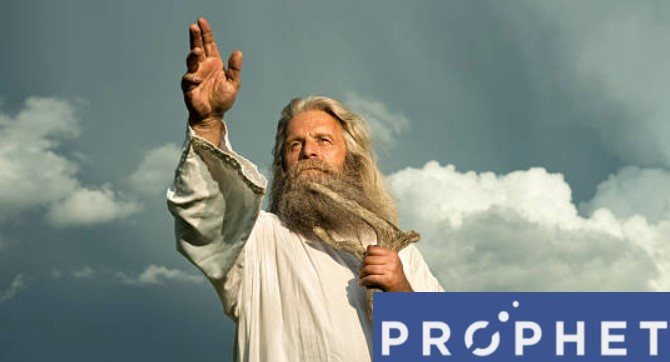

#  My other notebooks :
* [Basic EDA with visualization  and animated polar plot](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-data-exploration-animation) 
* [Looking for special values, EDA](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-1-special-values)
* [Features selection](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-the-less-the-better)
* [MultiOutput regressor, 65 targets in one](https://www.kaggle.com/code/martynovandrey/tps-mar-22-multioutput-cat-modeless)
* [Hybrid regressor, two step model](https://www.kaggle.com/code/martynovandrey/tps-mar-22-hybrid-regressors)
* [Multimodel regression, blendig, postprocessing - my best public score so far](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-model-selection)
* [How to use special values to improve submission, dataset shared](https://www.kaggle.com/code/martynovandrey/tps-mar-22-don-t-forget-special-values)

### Read data

In [ ]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
df_test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])
df_sample_submission = pd.read_csv('../input/tabular-playground-series-mar-2022/sample_submission.csv', index_col="row_id")
df_train_idx = df_train.index
df_test_idx = df_test.index

### x, y, directon -> road

In [ ]:
df_train['road'] = df_train['x'].astype(str) + df_train['y'].astype(str) + df_train['direction']
df_test['road']  = df_test['x'].astype(str) + df_test['y'].astype(str) + df_test['direction']
df_train = df_train.drop(['x', 'y', 'direction'], axis=1)
df_test = df_test.drop(['x', 'y', 'direction'], axis=1)

In [ ]:
def tic_to_time(tic):
    t = pd.to_datetime('1990-12-31 00:00') + pd.Timedelta(pd.offsets.Minute(tic*20))
    return pd.to_datetime(t)

def add_tics(df):
    df['tic'] = df['time'].dt.dayofyear * 72 + df['time'].dt.hour * 3 + df['time'].dt.minute // 20

def fill_missing_time(df_train):
    df = df_train[['time', 'road', 'congestion']]
    df['imputed'] = False
    add_tics(df)
    unique_tics = list(df.tic.unique())
    
    for tic in range(df.tic.min(), df.tic.max()+1):
        if not tic in unique_tics:
            pred, nxt = tic, tic
            while not pred in unique_tics:
                pred = int(pred - 1)
            while not nxt in unique_tics:
                nxt = int(nxt + 1)
            df_pred = df[df.tic == pred]
            df_next = df[df.tic == nxt]

            tmp = pd.concat([df_pred, df_next], axis=0)
            tmp_mean = tmp.drop(['time', 'imputed', 'tic'], axis=1).groupby(['road']).mean().reset_index()
            tmp_mean['congestion'] = tmp_mean['congestion'].round().astype(int)
            tmp_mean['tic'] = tic
            tmp_mean['time'] = tic_to_time(tic)
            tmp_mean['imputed'] = True
            tmp_mean = tmp_mean[df.columns].drop_duplicates()
            df = pd.concat([df, tmp_mean], axis=0)
    df = df.sort_values(by='tic')
    df = df.drop(['tic'], axis=1)
    return df

df_train = fill_missing_time(df_train)
df_train = df_train.drop(['imputed'], axis=1)
df_train = df_train.reset_index(drop=True)

In [ ]:
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20 
    
add_datetime_features(df_train)
add_datetime_features(df_test)    

In [ ]:
df_mornings = df_train[(df_train.hour >= 6) & (df_train.hour < 12)]
morning_avgs = pd.DataFrame(df_mornings.groupby(['month', 'day', 'road']).congestion.median().astype(int)).reset_index()
morning_avgs = morning_avgs.rename(columns={'congestion':'morning_avg'})
df_train = df_train.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_test = df_test.merge(morning_avgs, on=['month', 'day', 'road'], how='left')

mins = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.min().astype(int)).reset_index()
mins = mins.rename(columns={'congestion':'min'})
df_train = df_train.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')

maxs = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.max().astype(int)).reset_index()
maxs = maxs.rename(columns={'congestion':'max'})
df_train = df_train.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')

medians = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
medians = medians.rename(columns={'congestion':'median'})
df_train = df_train.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')

In [ ]:
important_features = ['moment', 'median', 'min', 'max', 'morning_avg']

X = df_train.copy()
X_t = df_test.copy()

y = X.pop('congestion')
X = X.loc[:, important_features]
X_t = X_t.loc[:, important_features]

from sklearn.decomposition import PCA

# Create principal components
pca = PCA(n_components=2) # 5 +0.012 public score
X_pca = pca.fit_transform(X)
X_t_pca = pca.transform(X_t)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_t_pca = pd.DataFrame(X_t_pca, columns=component_names)

df_train = pd.concat([df_train, X_pca], axis=1)
df_test = pd.concat([df_test, X_t_pca], axis=1)

In [ ]:
df_train = df_train.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)
df_test = df_test.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)

In [ ]:
df_train = df_train.rename(columns={'time':'ds', 'congestion':'y'})
df_test  = df_test.rename(columns={'time':'ds'})

### Split data ino 65 dataframes for train and test

In [ ]:
roads = df_train['road'].unique().tolist()

trains, tests = {}, {}
for road in roads:
    trains[road] = df_train[df_train.road == road].drop(['road'], axis=1)
    tests[road]  = df_test[df_test.road == road].drop(['road'], axis=1)

### Use Prophet

In [ ]:
output = pd.DataFrame()
for road in roads:
    print()
    print('ROADWAY ---------', road, '----------')
    print()
    model = ph()
    model.fit(trains[road])
    future_dates = tests[road][['ds']]
    future = model.predict(future_dates)
    future.index = tests[road].index
    output = pd.concat([output, future[['yhat']]], axis=0)
output   

### Submissions

In [ ]:
sub = output.sort_index()
sub.index = df_sample_submission.index
sub = sub.rename(columns={'yhat':'congestion'})
sub['congestion'] = sub['congestion'].round().astype(int)
sub.to_csv('prophet.csv')
sub

### Don't forget special values!

* [How to use special values to improve submission, dataset shared](https://www.kaggle.com/code/martynovandrey/tps-mar-22-don-t-forget-special-values)
* [Looking for special values, EDA](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-1-special-values)

In [ ]:
special = pd.read_csv('../input/tps-mar-22-special-values/special v2.csv', index_col="row_id")
special = special[['congestion']].rename(columns={'congestion':'special'})

In [ ]:
sub = sub.merge(special, left_index=True, right_index=True, how='left')
sub['special'] = sub['special'].fillna(sub['congestion']).round().astype(int)
sub = sub.drop(['congestion'], axis=1).rename(columns={'special':'congestion'})
sub.to_csv('prophet_specv2_rounded.csv', index=True)

### Generalizing the Special Values
* Thanks [Ambrosm](https://www.kaggle.com/ambrosm), [TPSMAR22 Generalizing the Special Values](https://www.kaggle.com/ambrosm/tpsmar22-generalizing-the-special-values)

In [ ]:
# Read and prepare the training data
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', parse_dates=['time'])
train['hour'] = train['time'].dt.hour
train['minute'] = train['time'].dt.minute

submission_in = sub.copy()
# Compute the quantiles of workday afternoons in September except Labor Day
sep = train[(train.time.dt.hour >= 12) & (train.time.dt.weekday < 5) &
            (train.time.dt.dayofyear >= 246)]
lower = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.15).values
upper = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.7).values

# Clip the submission data to the quantiles
submission_out = submission_in.copy()
submission_out['congestion'] = submission_in.congestion.clip(lower, upper)

# Display some statistics
mae = mean_absolute_error(submission_in.congestion, submission_out.congestion)
print(f'Mean absolute modification: {mae:.4f}')
print(f"Submission was below lower bound: {(submission_in.congestion <= lower - 0.5).sum()}")
print(f"Submission was above upper bound: {(submission_in.congestion > upper + 0.5).sum()}")

# Round the submission
submission_out['congestion'] = submission_out.congestion.round().astype(int)
submission_out.to_csv('prophet_corrected.csv')
submission_out